In [11]:
import numpy as np

A = np.array([
    [0, 0, 0, 1, 0],
    [0, 0, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
])

B = np.array([
    [0, 0, 0, 1, 0],
    [0, 0, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0]
])

(B & A).sum() / (B | A).sum()

0.8571428571428571

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import os
from PIL import Image
import torchvision


MODEL_PATH = "saved_models/model3.pth.tar"


def display_images_in_row(images, figsize=(9, 3)):
    fig, axis = plt.subplots(1, len(images), figsize=figsize)
    for ax, img in zip(axis, images):
        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

def read_images(dir_path, normalize=False):
    images = []
    for image_name in os.listdir(dir_path):
        img_path = os.path.join(dir_path, image_name)
        image = torch.Tensor(np.array((Image.open(img_path).convert("L").resize((960, 960))))).to("cuda")
        image = image.unsqueeze(0)
        images.append(image)
    return images

In [5]:
val_images = read_images("data/val_images")
val_masks = read_images("data/val_masks")
train_images = read_images("data/train_images")
train_masks = read_images("data/train_masks")
test_images = read_images("test/")

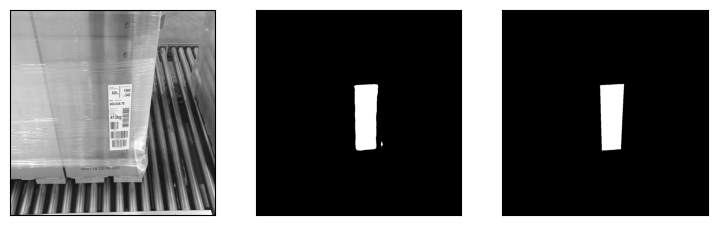

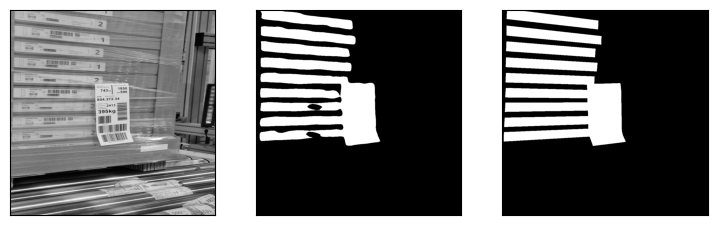

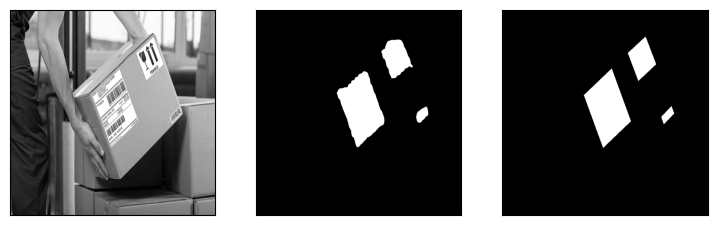

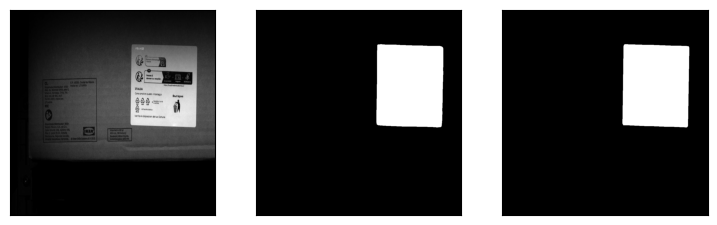

In [6]:
model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights="DEFAULT")
model.backbone["0"][0] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
model.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1))
model.load_state_dict(torch.load(MODEL_PATH))
model.to("cuda")
model.eval()

def test_deeplab(idx):
    with torch.no_grad():
        result = model.forward(train_images[idx].unsqueeze(0))["out"]
        display_images_in_row((
            train_images[idx].cpu().squeeze(0).detach(),
            torch.argmax(result, dim=1).cpu().detach().squeeze(0),
            train_masks[idx].cpu().squeeze(0).detach()
        ))

test_deeplab(1)
test_deeplab(10)
test_deeplab(16)
test_deeplab(100)

### On test data

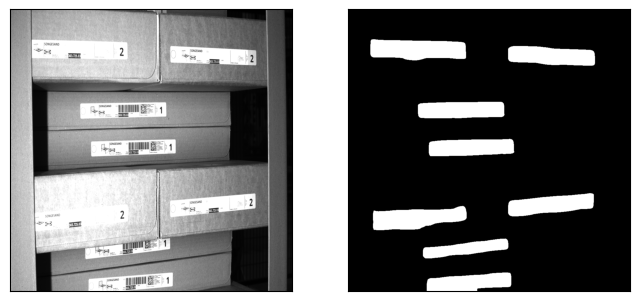

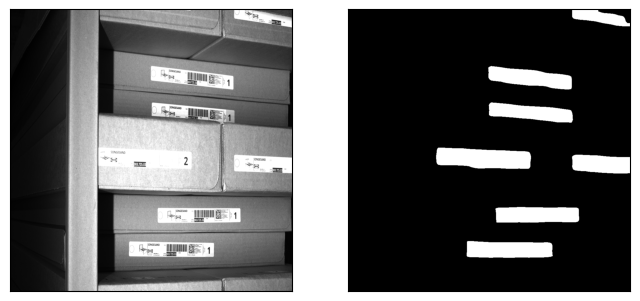

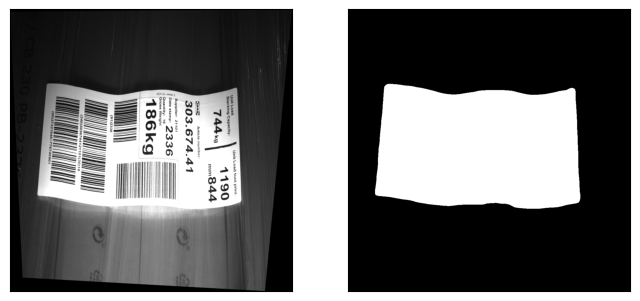

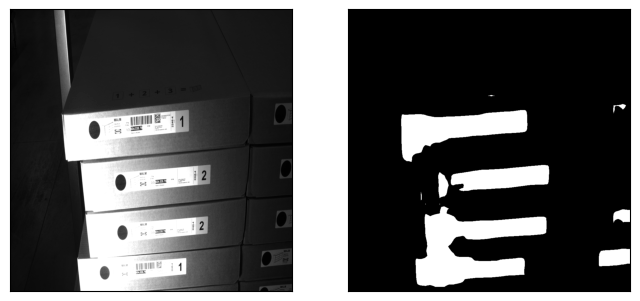

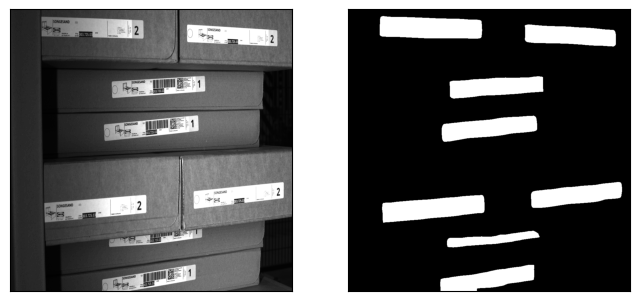

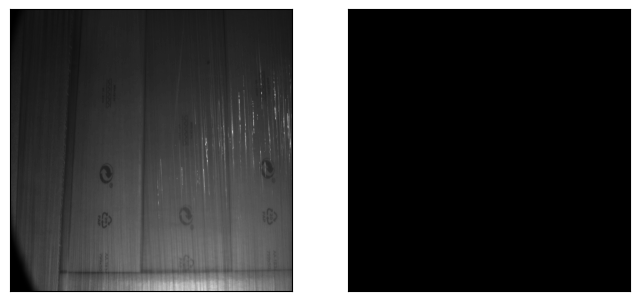

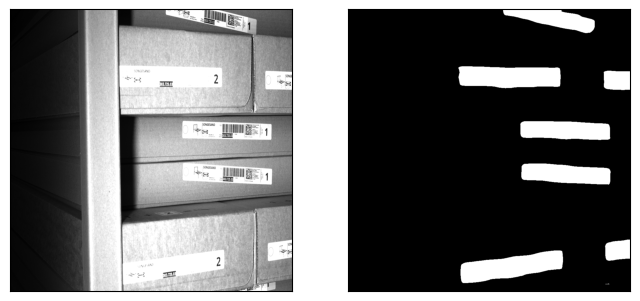

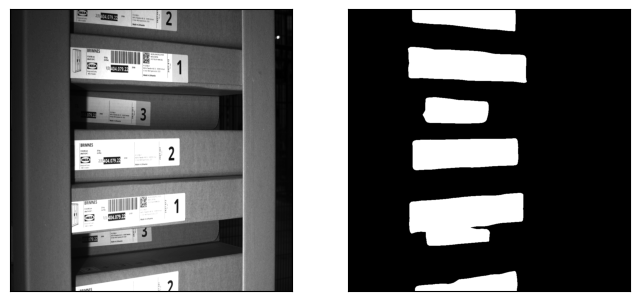

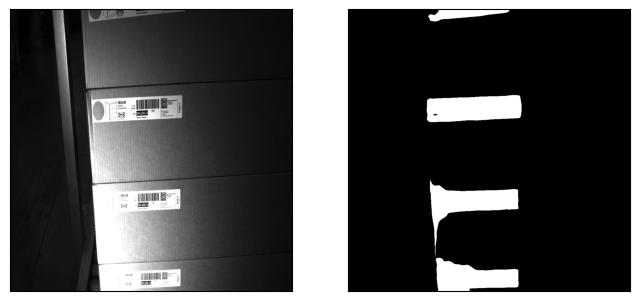

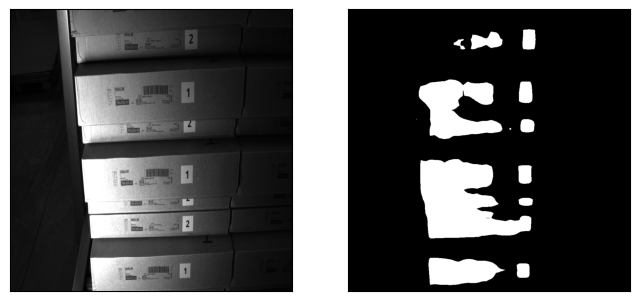

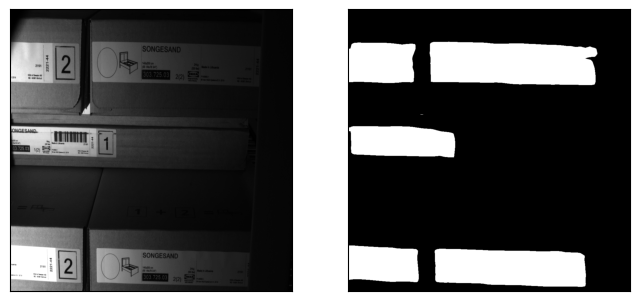

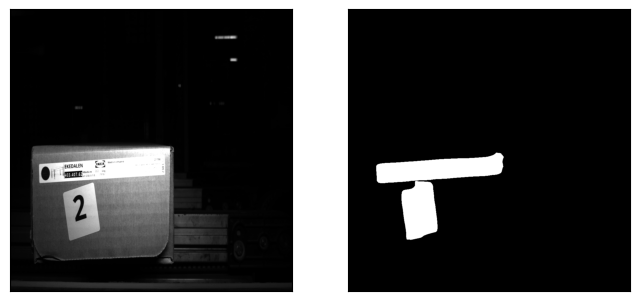

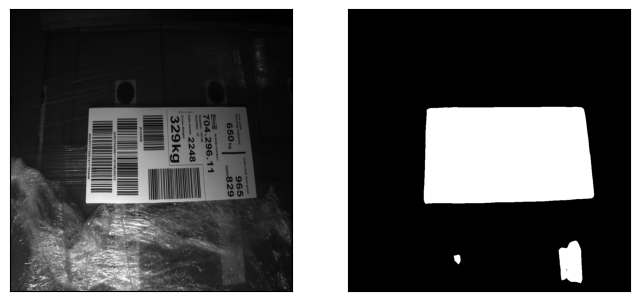

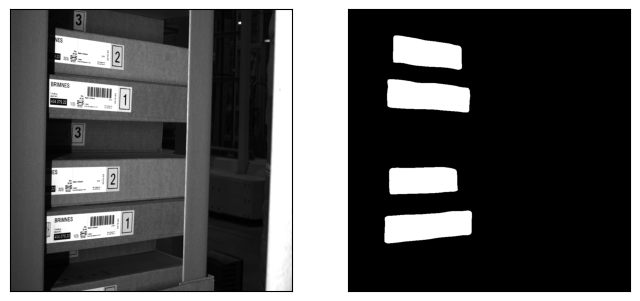

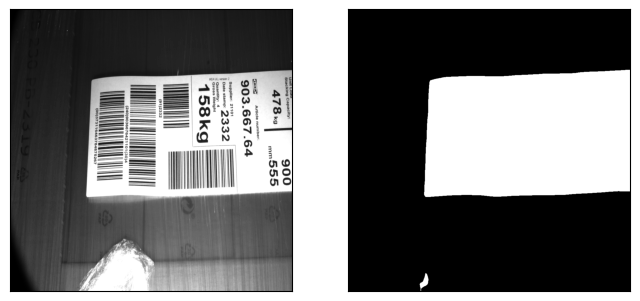

In [8]:
def test_deeplab(idx):
    result = model.forward(test_images[idx].unsqueeze(0))["out"].squeeze().squeeze()
    preds = torch.argmax(result, dim=0).cpu().detach().squeeze(0)
    display_images_in_row((
        test_images[idx].cpu().squeeze(0).detach(),
        preds
    ), (8, 4))

for i in range(len(test_images)):
    test_deeplab(i)

### On val data

IoU score: 0.4560


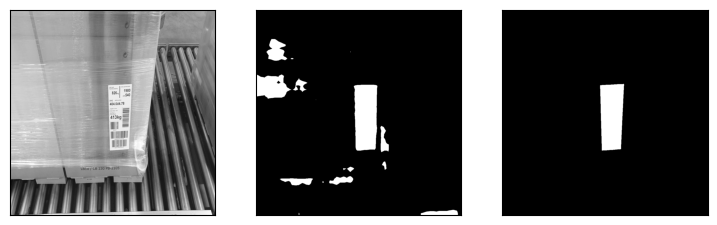

IoU score: 0.3780


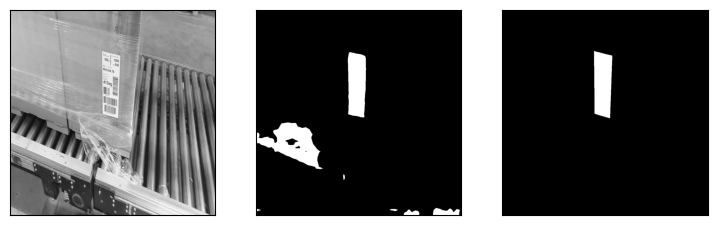

IoU score: 0.7298


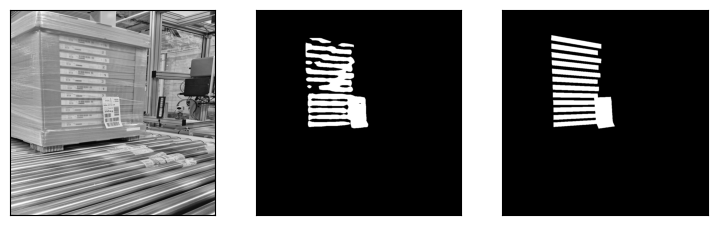

IoU score: 0.8964


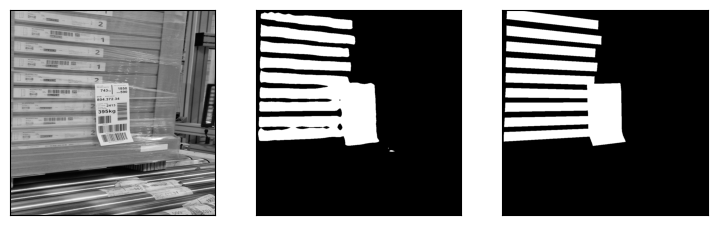

IoU score: 0.9189


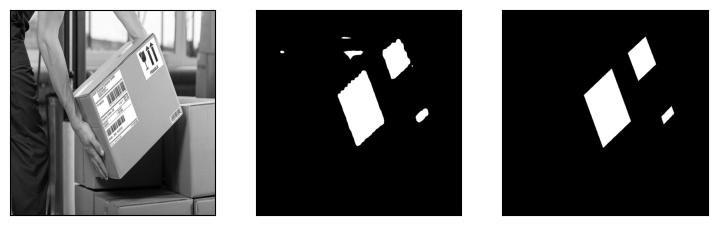

IoU score: 0.9934


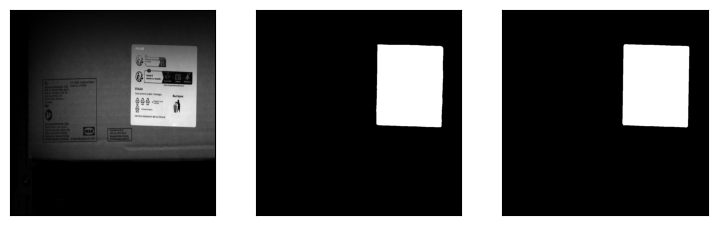

In [5]:
model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights="DEFAULT")
model.backbone["0"][0] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
model.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1))
model.load_state_dict(torch.load(MODEL_PATH))
model.to("cuda")
model.train()

def test_deeplab(idx):
    with torch.no_grad():
        result = model.forward(torch.cat(train_images[idx:idx+2]).unsqueeze(1))["out"][0]
        #result = model.forward(train_images[idx:idx+1].unsqueeze(0))["out"]
        preds = torch.argmax(result, dim=0).cpu().detach().squeeze(0)
        masks = torch.where(train_masks[idx].cpu().squeeze(0).detach() > 0, 1, 0).long()
        iou = (preds & masks).sum() / (preds | masks).sum()
        print(f"IoU score: {iou.item():.4f}")
        display_images_in_row((
            train_images[idx].cpu().squeeze(0).detach(),
            preds,
            masks
        ))

test_deeplab(1)
test_deeplab(5)
test_deeplab(9)
test_deeplab(10)
test_deeplab(16)
test_deeplab(100)

IoU score: 0.8065


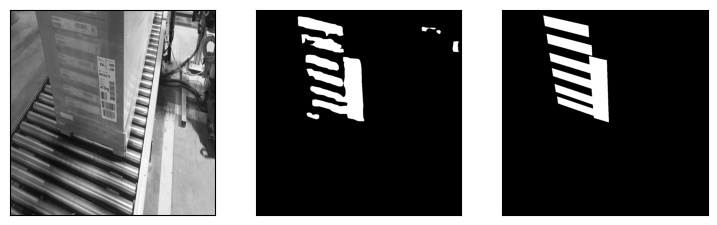

IoU score: 0.5129


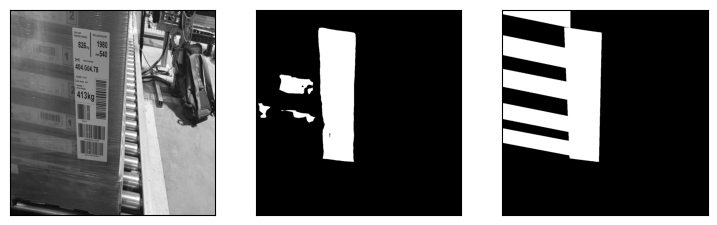

IoU score: 0.5515


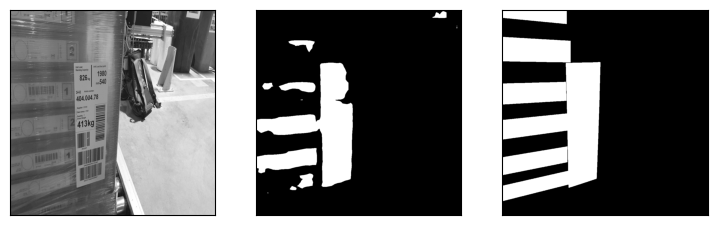

IoU score: 0.9241


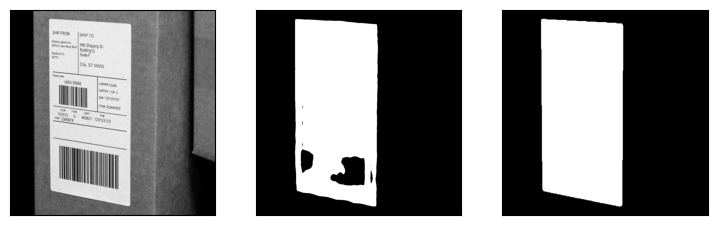

IoU score: 0.9934


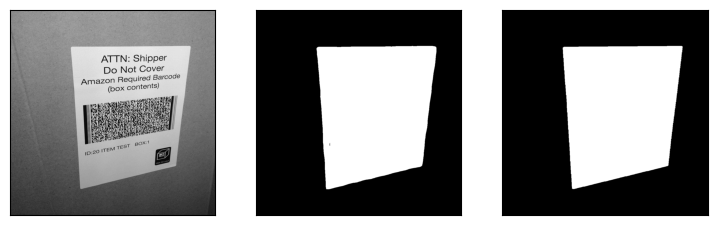

IoU score: 0.8704


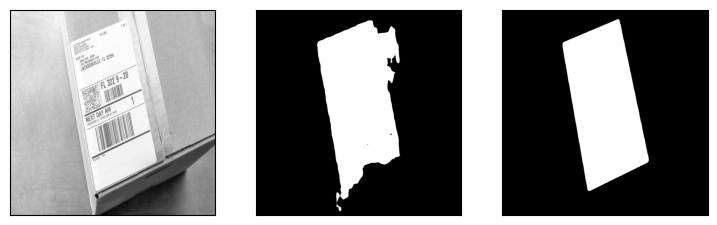

IoU score: 0.9907


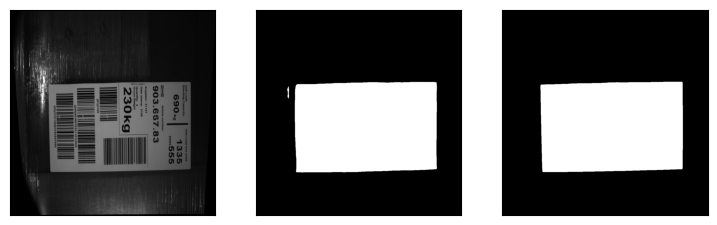

IoU score: 0.9896


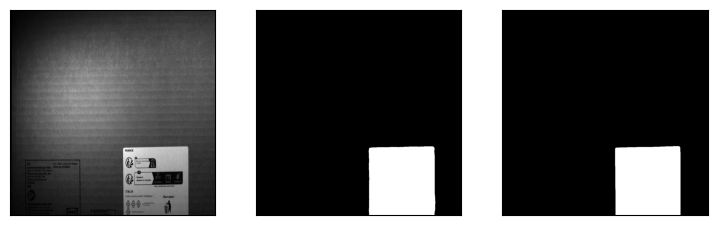

IoU score: 0.9911


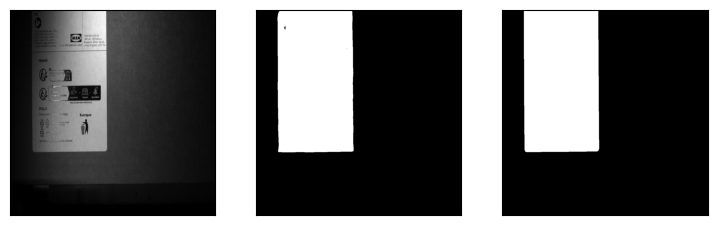

IoU score: 0.9896


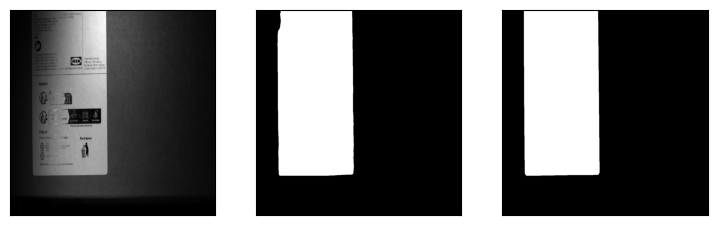

IoU score: 0.9862


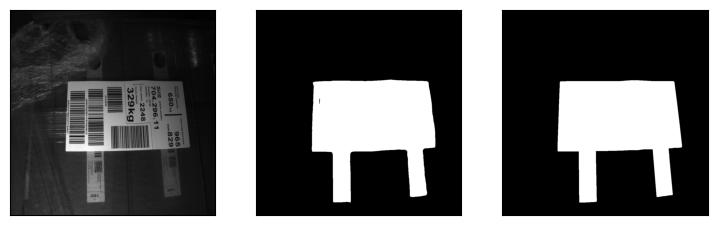

IoU score: 0.9668


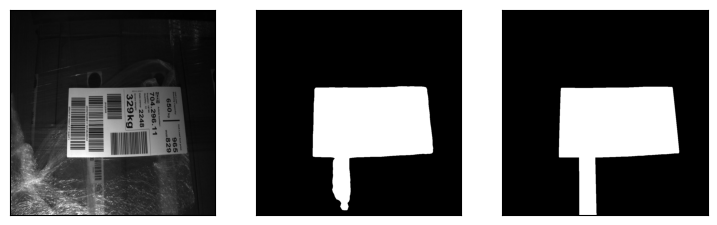

IoU score: 0.9830


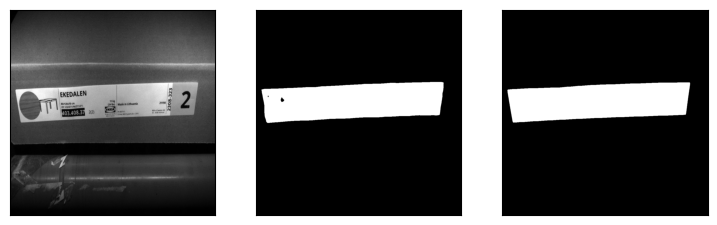

IoU score: 0.9810


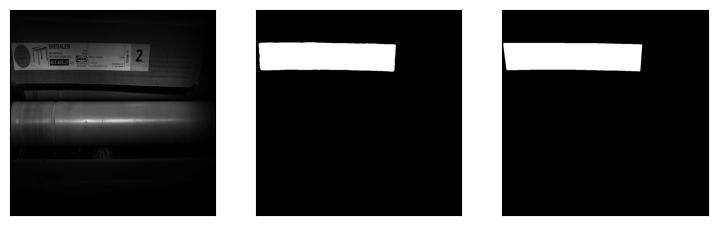

IoU score: 0.9729


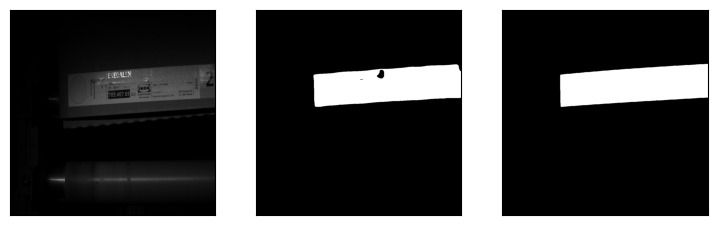

IoU score: 0.9878


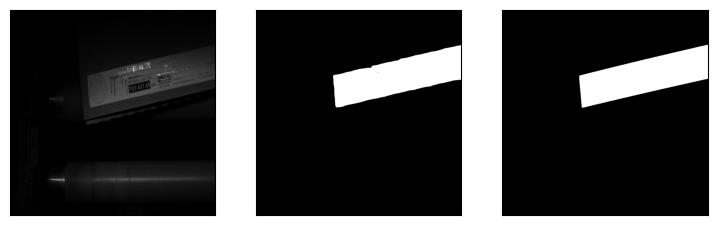

IoU score: 0.9486


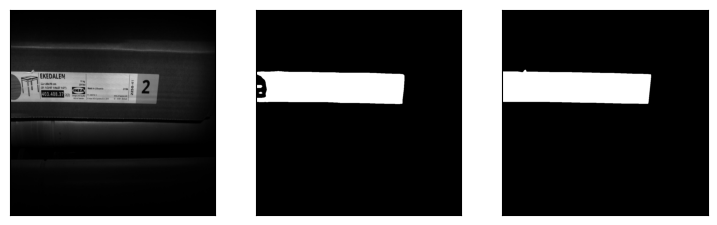

IoU score: 0.9886


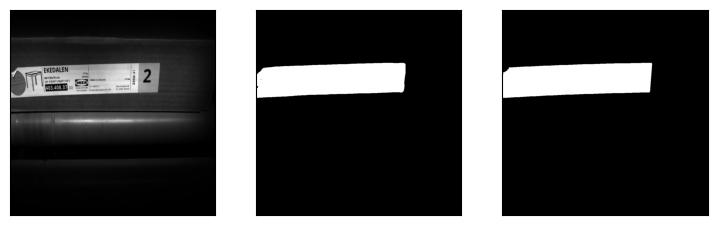

IoU score: 0.9051


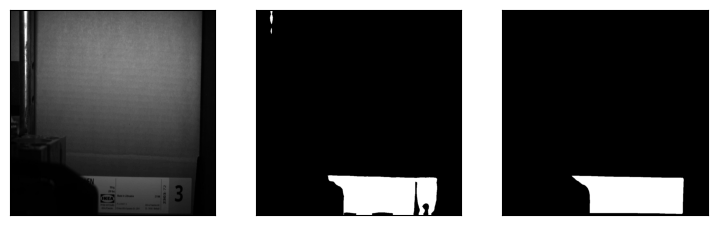

IoU score: 0.9562


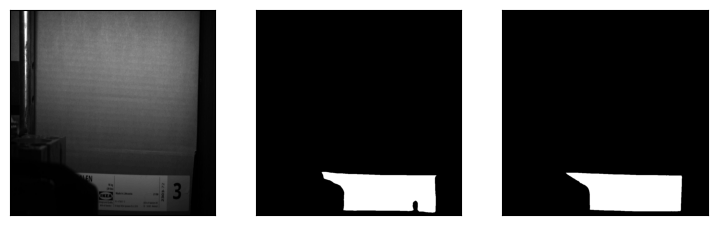

In [6]:
model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights="DEFAULT")
model.backbone["0"][0] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
model.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1))
model.load_state_dict(torch.load(MODEL_PATH))
model.to("cuda")
model.train()

def test_deeplab(idx):
    with torch.no_grad():
        result = model.forward(torch.cat(val_images[idx:idx+2]).unsqueeze(1))["out"][0]
        #result = model.forward(train_images[idx:idx+1].unsqueeze(0))["out"]
        preds = torch.argmax(result, dim=0).cpu().detach().squeeze(0)
        masks = torch.where(val_masks[idx].cpu().squeeze(0).detach() > 0, 1, 0).long()
        iou = (preds & masks).sum() / (preds | masks).sum()
        print(f"IoU score: {iou.item():.4f}")
        display_images_in_row((
            val_images[idx].cpu().squeeze(0).detach(),
            preds,
            masks
        ))

for i in range(20):
    test_deeplab(i)

### Exporting model

In [53]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params / 1e6}M")

Number of parameters: 11.024157M


In [55]:
traced_script_module = torch.jit.trace(model, train_images[0].unsqueeze(0), strict=False)
traced_script_module.save("deeplab_exported.torchscript")